2025-05-29 09:08:29,965 - config.settings - INFO - Tentando buscar dados para plotagem: 'FRED WTI Crude Oil Spot Price (Daily)'


Raiz do projeto assumida/adicionada ao sys.path: c:\ArgusAnalytics\ArgusAnalytics-Core
Conectado ao PostgreSQL: localhost:5432/argus_config?client_encoding=utf8

--- Indicadores Disponíveis (correspondendo ao termo de busca, se houver) ---
   indicator_id  \
0            70   
1            71   
2            68   
3            74   
4            72   
5            73   
6            69   

                                                                     name  \
0                                 FRED Brent Crude Oil Spot Price (Daily)   
1                          FRED CBOE Crude Oil ETF Volatility Index (OVX)   
2                               FRED Federal Funds Effective Rate (Daily)   
3  FRED Trade Weighted US Dollar Index: Broad, Goods and Services (Daily)   
4                 FRED US 10-Year Treasury Constant Maturity Rate (Daily)   
5                           FRED US CPI All Urban Consumers (SA, Monthly)   
6                                   FRED WTI Crude Oil Spot Price (D

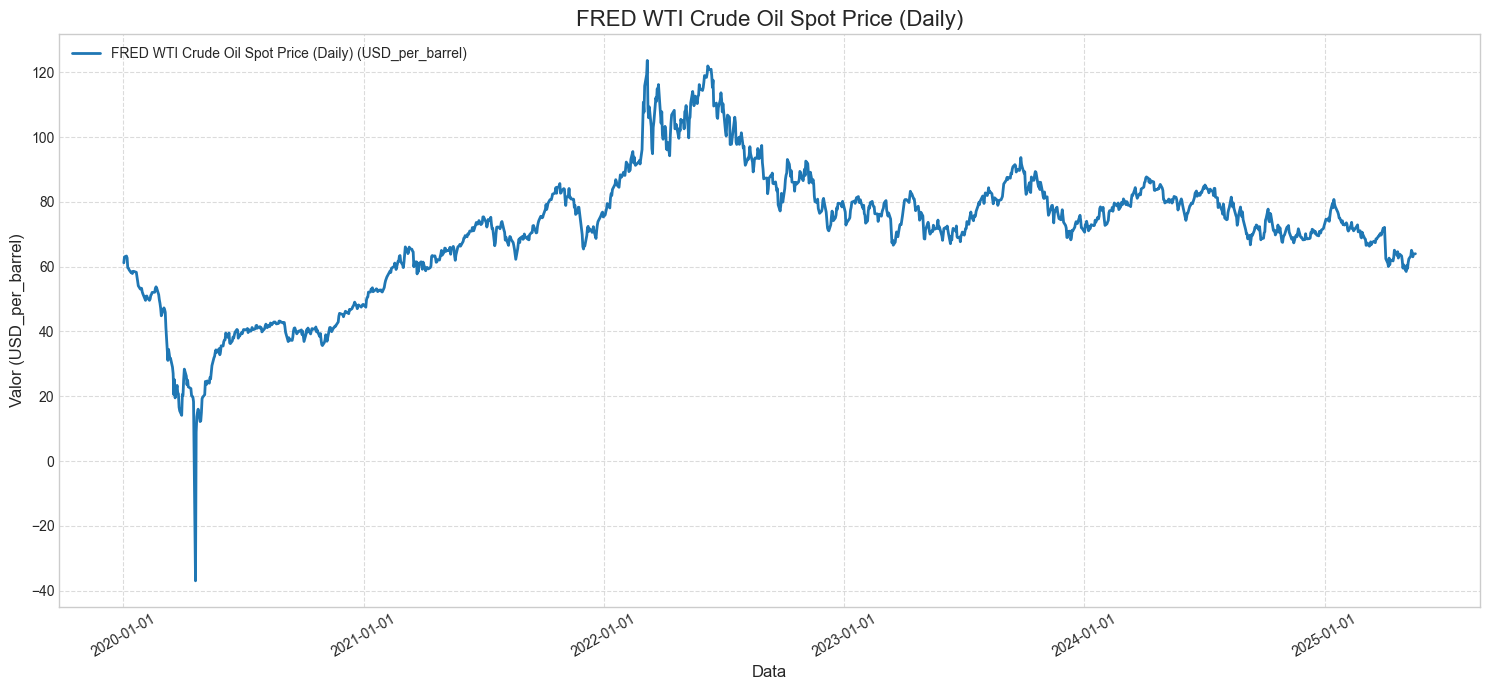

Sessão do banco de dados fechada.


In [15]:
import pandas as pd
from sqlalchemy import create_engine, select, text, Column, Integer, String, Date, Float, ForeignKey, DateTime
from sqlalchemy.orm import sessionmaker, Session as SQLAlchemySession, declarative_base
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import sys

# --- Configuração para encontrar o módulo config e os modelos do BD ---
try:
    current_dir = os.getcwd()
    project_root = None
    for i in range(4): 
        path_to_check = os.path.abspath(os.path.join(current_dir, *[".."]*i))
        if "config" in os.listdir(path_to_check) and "src" in os.listdir(path_to_check):
            project_root = path_to_check
            break
    if not project_root:
        print("Não foi possível determinar a raiz do projeto automaticamente. Verifique os caminhos.")
        # project_root = "C:/ArgusAnalytics/ArgusAnalytics-Core" # Defina manualmente se necessário
        raise FileNotFoundError("Raiz do projeto não encontrada.")
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    print(f"Raiz do projeto assumida/adicionada ao sys.path: {project_root}")

    from config import settings
    from src.database.create_db_tables import Base, EconomicIndicator, EconomicIndicatorValue, Company
except ImportError as e:
    print(f"Erro ao importar módulos necessários: {e}")
    raise
except FileNotFoundError as e:
    print(e)
    raise

# --- Conexão com o Banco de Dados ---
engine = None
SessionLocal = None
try:
    if not settings.ACTIVE_DATABASE_URL:
        raise ValueError("ACTIVE_DATABASE_URL não está configurada em settings.py")
    engine = create_engine(settings.ACTIVE_DATABASE_URL, echo=False)
    SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
    with engine.connect() as connection: # Testa a conexão
        print(f"Conectado ao PostgreSQL: {str(engine.url).split('@')[-1] if '@' in str(engine.url) else str(engine.url)}")
except Exception as e:
    print(f"Erro ao criar engine do BD ou conectar: {e}")
    raise

# --- Função para Listar Indicadores Disponíveis (para ajudar a encontrar o nome exato) ---
def list_available_indicators(dbsession: SQLAlchemySession, search_term: str = None):
    """Lista indicadores disponíveis, opcionalmente filtrando por um termo de busca."""
    stmt = select(EconomicIndicator.indicator_id, 
                  EconomicIndicator.name, 
                  EconomicIndicator.indicator_type, # <--- CORREÇÃO
                  EconomicIndicator.unit)
    if search_term:
        stmt = stmt.filter(EconomicIndicator.name.ilike(f"%{search_term}%"))
    stmt = stmt.order_by(EconomicIndicator.name)
    
    df = pd.read_sql_query(stmt, dbsession.bind)
    if not df.empty:
        print("\n--- Indicadores Disponíveis (correspondendo ao termo de busca, se houver) ---")
        with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
            print(df)
        print("--------------------------------------------------------------------")
    else:
        print(f"Nenhum indicador encontrado com o termo de busca: '{search_term if search_term else 'todos'}'.")
    return df

# --- Função para Buscar Dados de um Único Indicador ---
def fetch_single_indicator_data(dbsession: SQLAlchemySession, 
                                indicator_name_exact: str, 
                                company_ticker_exact: str = None, 
                                start_date_str: str = None, 
                                end_date_str: str = None):
    """
    Busca dados de UM indicador específico do banco de dados.
    indicator_name_exact: Nome EXATO do indicador na tabela EconomicIndicators.
    company_ticker_exact: Ticker EXATO da empresa, se for um indicador específico de empresa.
    """
    stmt = select(
        EconomicIndicatorValue.effective_date,
        EconomicIndicatorValue.value_numeric,
        EconomicIndicator.name.label("indicator_name"),
        EconomicIndicator.unit.label("unit")
    ).join(EconomicIndicator, EconomicIndicatorValue.indicator_id == EconomicIndicator.indicator_id)\
     .filter(EconomicIndicator.name == indicator_name_exact)\
     .order_by(EconomicIndicatorValue.effective_date.asc())

    if company_ticker_exact:
        # Subconsulta para pegar o company_id pelo ticker
        company_id_stmt = select(Company.company_id).where(Company.ticker == company_ticker_exact)
        company_id_result = dbsession.execute(company_id_stmt).scalar_one_or_none()
        if company_id_result is None:
            settings.logger.warning(f"Nenhuma empresa encontrada com o ticker '{company_ticker_exact}'. Buscando indicador sem filtro de empresa.")
            stmt = stmt.filter(EconomicIndicatorValue.company_id.is_(None)) # Assume que é um indicador geral se a empresa não for encontrada
        else:
            stmt = stmt.filter(EconomicIndicatorValue.company_id == company_id_result)
    else:
        pass 
        #stmt = stmt.filter(EconomicIndicatorValue.company_id.is_(None))
        
    if start_date_str:
        try:
            stmt = stmt.filter(EconomicIndicatorValue.effective_date >= pd.to_datetime(start_date_str).date())
        except Exception as e:
            print(f"Formato de data inválido para start_date_str ('{start_date_str}'): {e}")
            return pd.DataFrame()
            
    if end_date_str:
        try:
            stmt = stmt.filter(EconomicIndicatorValue.effective_date <= pd.to_datetime(end_date_str).date())
        except Exception as e:
            print(f"Formato de data inválido para end_date_str ('{end_date_str}'): {e}")
            return pd.DataFrame()

    try:
        df = pd.read_sql_query(stmt, dbsession.bind)
        if not df.empty:
            df['effective_date'] = pd.to_datetime(df['effective_date'])
            df = df.set_index('effective_date')
        return df
    except Exception as e:
        print(f"Erro ao executar a consulta para '{indicator_name_exact}': {e}")
        return pd.DataFrame()

# --- Parâmetros para Plotagem ---
# MODIFIQUE ESTES VALORES PARA O INDICADOR QUE VOCÊ QUER PLOTAR:
INDICATOR_NAME_TO_PLOT = "FRED WTI Crude Oil Spot Price (Daily)" # Nome EXATO do indicador no BD
COMPANY_TICKER_TO_PLOT = None  # Ex: "PETR4.SA" ou None se for um indicador macro/geral
PLOT_START_DATE = "2020-01-01" # Data de início para o gráfico (opcional)
# PLOT_END_DATE = "2025-05-29"   # Data de fim para o gráfico (opcional)

# --- Buscar e Plotar o Indicador Especificado ---
if SessionLocal:
    db = SessionLocal()
    try:
        # Primeiro, liste alguns indicadores para ajudar a encontrar o nome exato (opcional)
        # list_available_indicators(db, search_term="FRED WTI") # Exemplo de busca
        list_available_indicators(db, search_term=INDICATOR_NAME_TO_PLOT.split(" ")[0]) # Busca pelo primeiro nome
        
        settings.logger.info(f"Tentando buscar dados para plotagem: '{INDICATOR_NAME_TO_PLOT}'")
        df_indicator_to_plot = fetch_single_indicator_data(
            db, 
            indicator_name_exact=INDICATOR_NAME_TO_PLOT,
            company_ticker_exact=COMPANY_TICKER_TO_PLOT,
            start_date_str=PLOT_START_DATE
            # end_date_str=PLOT_END_DATE # Descomente se quiser definir uma data final
        )
        
        plt.style.use('seaborn-v0_8-whitegrid') # Tente um estilo que funcione para você
        plt.figure(figsize=(15, 7))

        if not df_indicator_to_plot.empty and 'value_numeric' in df_indicator_to_plot.columns:
            unit = df_indicator_to_plot['unit'].iloc[0] if 'unit' in df_indicator_to_plot.columns and not df_indicator_to_plot['unit'].empty else ""
            plt.plot(df_indicator_to_plot.index, df_indicator_to_plot['value_numeric'], label=f"{INDICATOR_NAME_TO_PLOT} ({unit})", linewidth=2)
            
            title = INDICATOR_NAME_TO_PLOT
            if COMPANY_TICKER_TO_PLOT:
                title = f"{COMPANY_TICKER_TO_PLOT} - {INDICATOR_NAME_TO_PLOT}"
            plt.title(title, fontsize=16)
            
            plt.xlabel("Data", fontsize=12)
            plt.ylabel(f"Valor ({unit})", fontsize=12)
            plt.legend(loc='upper left', fontsize=10)
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Formato AAAA-MM-DD
            plt.tick_params(axis='x', rotation=30, labelsize=10)
            plt.tick_params(axis='y', labelsize=10)
            plt.grid(True, linestyle='--', alpha=0.7)
        else:
            plt.title(f"'{INDICATOR_NAME_TO_PLOT}' - Nenhum dado encontrado no período ou para este nome/ticker.", fontsize=12)
            settings.logger.warning(f"Nenhum dado encontrado para plotar: '{INDICATOR_NAME_TO_PLOT}' (Ticker: {COMPANY_TICKER_TO_PLOT}) no período a partir de {PLOT_START_DATE}")

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro ao buscar ou plotar dados: {e}")
        settings.logger.error(f"Erro no notebook de plotagem: {e}", exc_info=True)
    finally:
        if db:
            db.close()
            print("Sessão do banco de dados fechada.")
else:
    print("Não foi possível estabelecer conexão com o banco de dados para plotagem.")